Bank wants to figure out why customers are leaving at unnatural rates...

In [123]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [124]:
def visual(df,plot_type):
    plt.rcParams["figure.figsize"] = (23,13)
    fig,ax = plt.subplots(nrows=3,ncols=4)
    i = 0
    j = 0
    
    if plot_type == "hist":
        for col in df.columns:
            ax[i,j].hist(df[col],alpha=0.5,label=col)
            ax[i,j].set_title(col + " Distribution")
            if j == 3:
                i += 1
                j = 0
            else:
                j += 1
    elif plot_type == "box":
        for col in df.columns:
            ax[i,j].boxplot(df[col])
            ax[i,j].set_title(col)
            if j == 3:
                i += 1
                j = 0
            else:
                j += 1
    else:
        print("Please chooose 'hist' or 'box' for plot_type")
    
    fig.delaxes(ax[2,3])
    fig.tight_layout()
    plt.show()

In [125]:
data = pd.read_csv("Churn_Modelling.csv")
data.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


In [126]:
data.shape

(10000, 14)

## Preprocessing

In [127]:
# check for NA values
data.isnull().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

Some relevant features for determining churn are:

1. CreditScore
2. Geography
3. Gender
4. Age
5. Tenure
6. Balance
7. NumOfProducts
8. HasCrCard
9. IsActiveMember
10. EstimatedSalary

In [128]:
X = data.iloc[:,3:13]
y = data.iloc[:,-1]

In [129]:
X.dtypes

CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
dtype: object

In [130]:
# create dummy variables for categorical independent features (drop_first = avoid dummy variable trap)
X = pd.get_dummies(X,["Geography","Gender"],drop_first=True)

In [131]:
X.head(3)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2,0.00,1,1,1,101348.88,0,0,0
1,608,41,1,83807.86,1,0,1,112542.58,0,1,0
2,502,42,8,159660.80,3,1,0,113931.57,0,0,0


In [132]:
X.shape

(10000, 11)

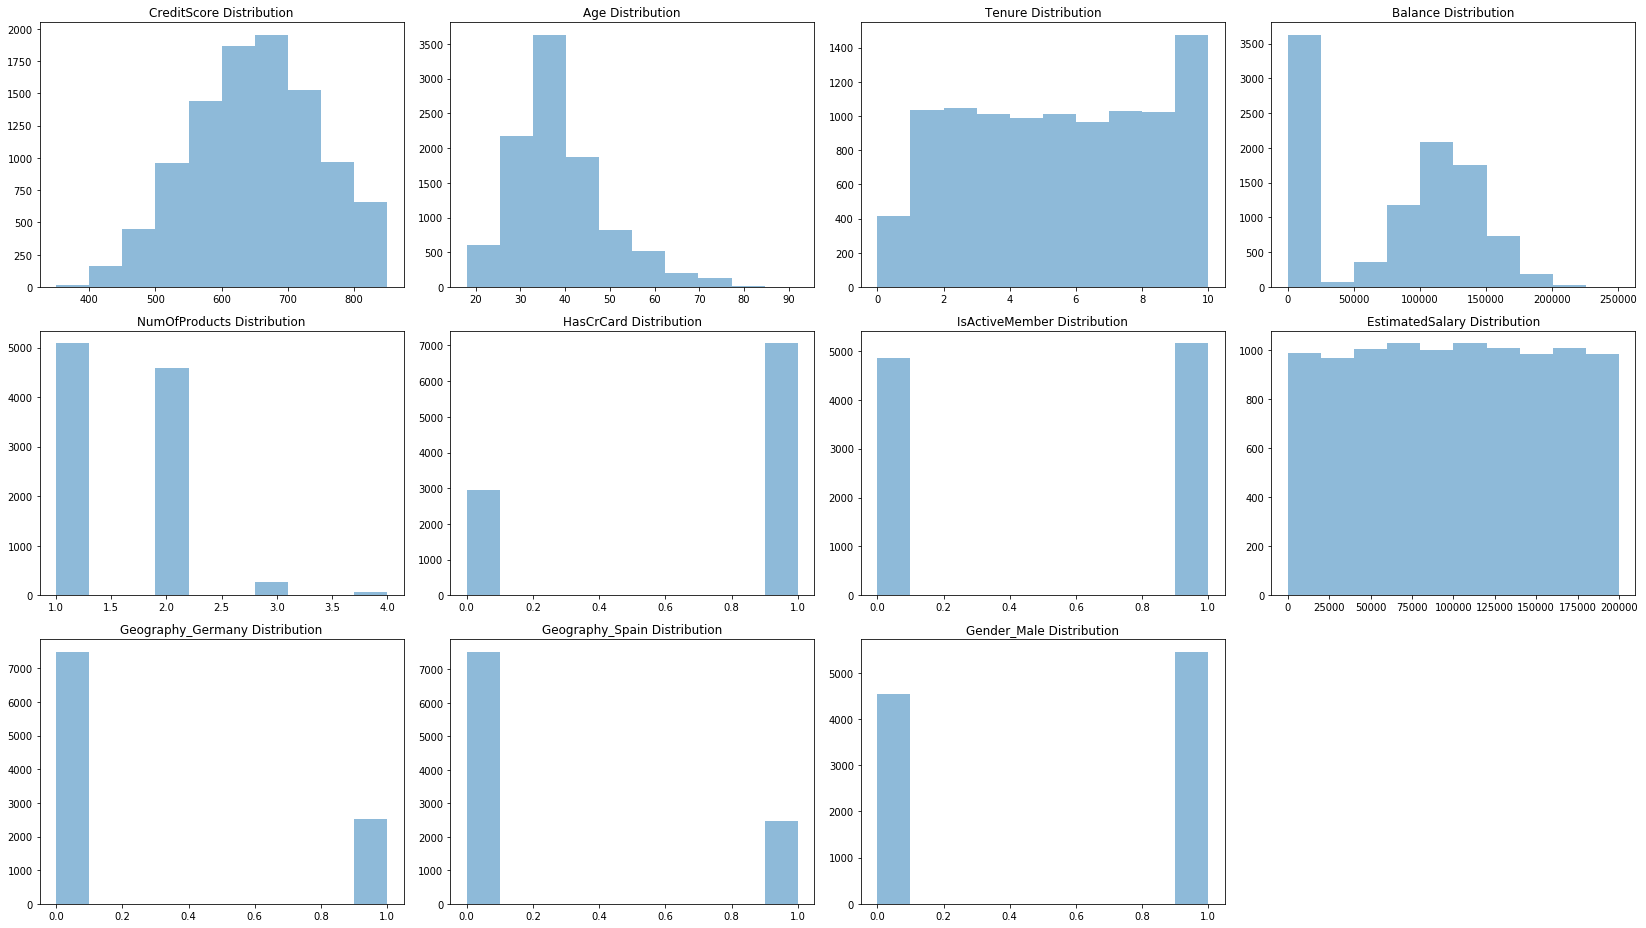

In [133]:
# visualize distribution of independent variables
visual(X,"hist")

Found scaling data before splitting into train and test groups didn't accomplish significant change in distribution, which was expected. In future, can scale data after splitting into train/test groups. 

In [134]:
# remove significant outliers
#from scipy import stats

#z = np.abs(stats.zscore(X))

In [135]:
#X= X[(z<=2).all(axis=1)]
#X.shape

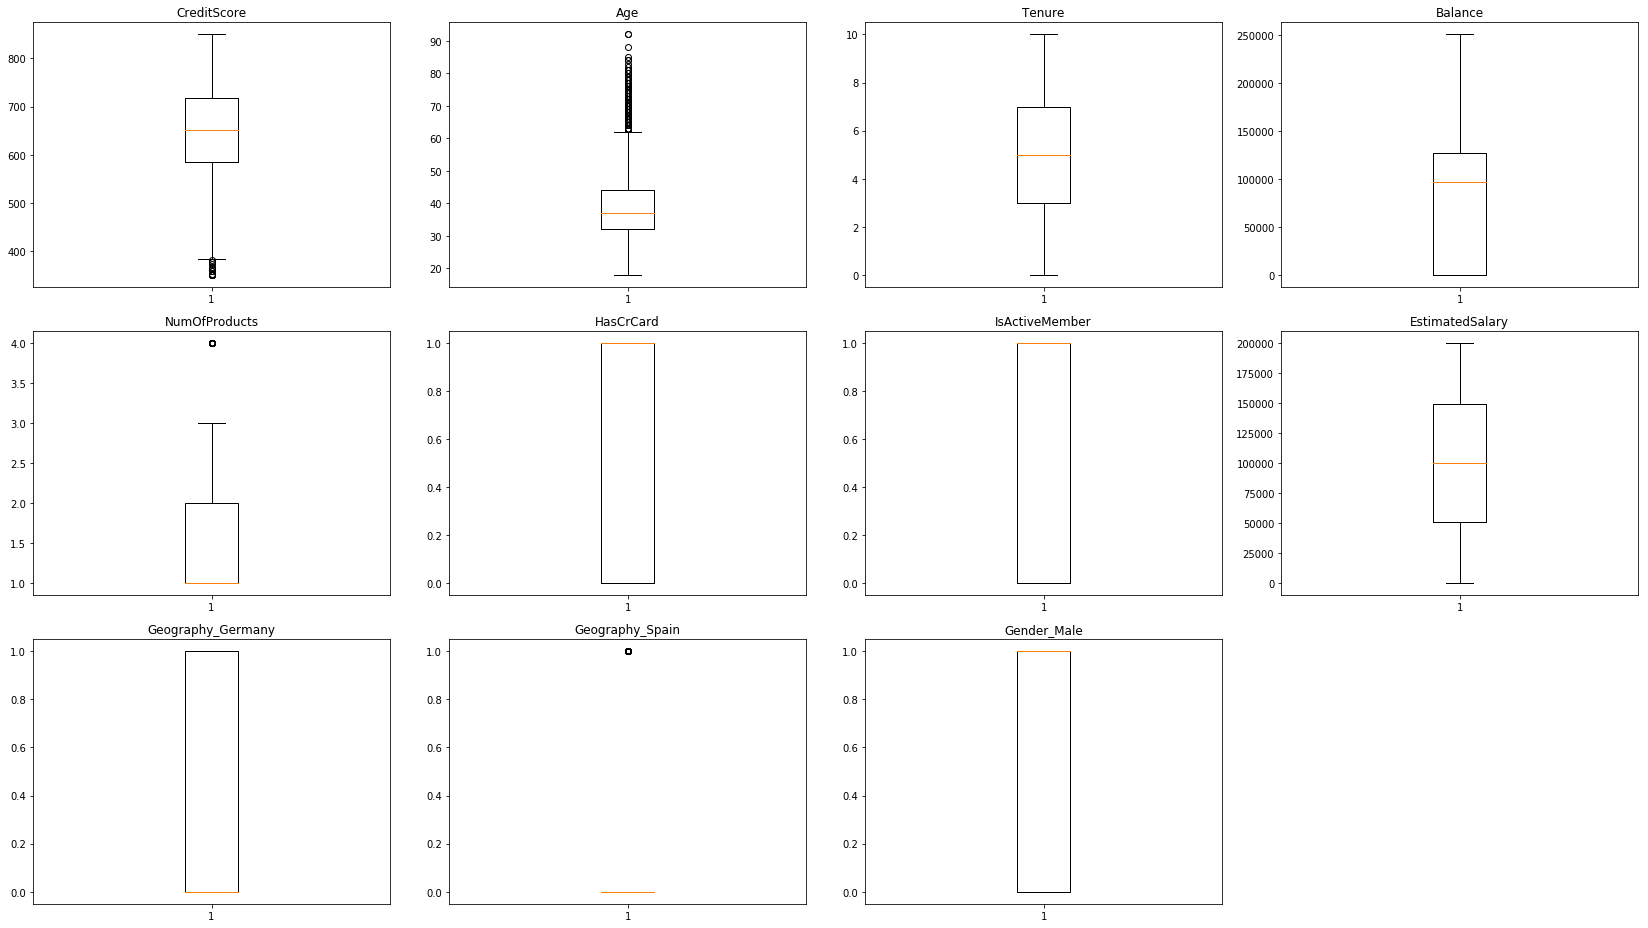

In [136]:
visual(X,"box")

Removed some outliers from dataset which could have a negative impact on the accuracy of our model (less information).

In [137]:
# visualize class balance of target variable
target = y.value_counts()

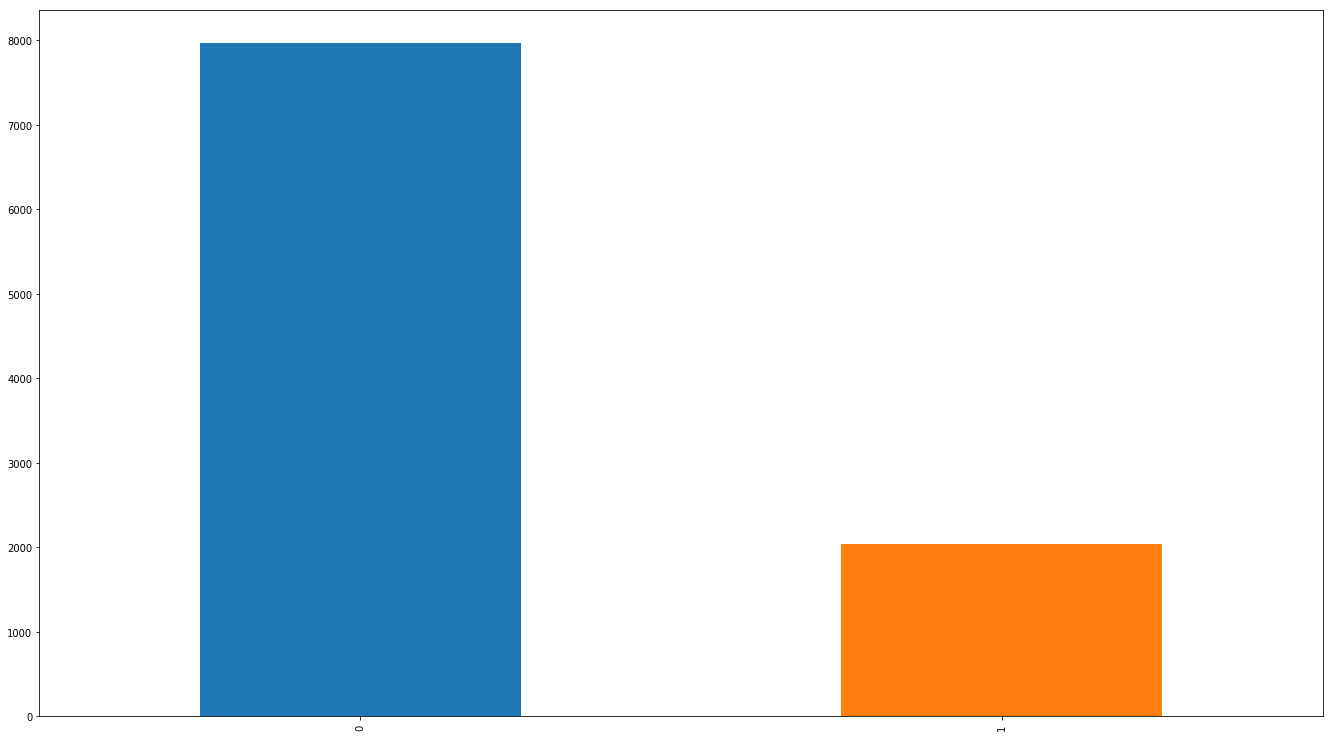

In [138]:
target.plot(kind="bar")
plt.show()

In [139]:
print(target)

0    7963
1    2037
Name: Exited, dtype: int64


In [140]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X.values,y.values,test_size=0.2,random_state=42)

In [141]:
from imblearn.over_sampling import SMOTE

print("Before oversampling, counts of label '1': {}, counts of label '0': {}".format(sum(y_train==1),sum(y_train==0)))
sm = SMOTE()
X_train_res,y_train_res = sm.fit_sample(X_train,y_train.ravel())
print("After oversampling, counts of label '1': {}, counts of label '0': {}".format(sum(y_train_res==1),sum(y_train_res==0)))

Before oversampling, counts of label '1': 1644, counts of label '0': 6356
After oversampling, counts of label '1': 6356, counts of label '0': 6356


In [142]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

## Creating ANN

Bank wants to figure out why customer churn rate is high...

In [143]:
import keras
from keras.models import Sequential
from keras.layers import Dense

classifier = Sequential()

In [144]:
def create_network():
    # output_dim = independent features (11) + dependent features (1) / 2 --> 6 
    # creating input layer
    classifier.add(Dense(units = 6, kernel_initializer = "uniform", activation = "relu",input_dim = 11))
    # creating hidden layer
    classifier.add(Dense(units = 6, kernel_initializer = "uniform", activation = "relu"))
    classifier.add(Dense(units = 6, kernel_initializer = "uniform", activation = "relu"))
    classifier.add(Dense(units = 6, kernel_initializer = "uniform", activation = "relu"))
    # creating output layer
    classifier.add(Dense(units = 1, kernel_initializer = "uniform", activation = "sigmoid"))
    classifier.compile(optimizer = "adam", loss = "binary_crossentropy", metrics= ["accuracy"])
    return classifier

In [145]:
from keras.wrappers.scikit_learn import KerasClassifier

neural_network = KerasClassifier(build_fn = create_network,
                                epochs = 100,
                                batch_size = 10,
                                verbose = 0)

In [149]:
neural_network.fit(X_train,y_train)

In [150]:
y_pred = neural_network.predict(X_test)

In [151]:
# change probabilities into 0 or 1
y_pred = (y_pred > 0.5)

In [152]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test,y_pred)
print(cm)

[[1542   65]
 [ 210  183]]


### ANN with 1 hidden layer

Customer Churn correctly classified: (1550 + 135) / 2000 (84.25%)

Customer Churn incorrectly classified: (57 + 258) / 2000 (15.75%)

False Positive: 258/393

False Negative: 57/1607 

Sensitivity: 135/393

Specificity: 1550/1607

### ANN with 2 hidden layers

Customer Churn correctly classified: (1545 + 140) / 2000 (84.25%)

Customer Churn incorrectly classified: (62 + 253) / 2000 (15.75%)

False Positive: 253/393

False Negative: 62/1607

Sensitivity: 140/393

Specificity: 1545/1607

### ANN with 3 hidden layers

Customer Churn correctly classified: (1562 + 116) / 2000 (83.90%)

Customer Churn incorrectly classified: (45 + 277) / 2000 (16.10%)

False Positive: 277/393

False Negative: 45/1607

Sensitivity: 116/393

Specificity: 1562/1607

It appears that 1 to 2 hidden layers are optimal for this dataset.